In [17]:
# conda env: tahoe
import numpy as np
import pandas as pd
import anndata as ann
import json
import re
from tqdm import tqdm

In [2]:
tahoe_path = "/nfs/dcmb-lgarmire/yangiwen/workspace/pdac/data/tahoe/Tahoe-100M/tahoe.h5ad"
lincs_path = "/home/wanxingz/project/STDrug/dataset/l1000_phaseI_II.h5ad"

## Load files

In [3]:
tahoe = ann.read_h5ad(tahoe_path) 

tahoe

AnnData object with n_obs × n_vars = 67018 × 62710
    obs: 'sample', 'cell_line_id'
    var: 'ensembl_id'

In [4]:
display(tahoe.obs.head())
display(tahoe.var.head())

,sample,cell_line_id
smp_1495_CVCL_0023,smp_1495,CVCL_0023
smp_1495_CVCL_0028,smp_1495,CVCL_0028
smp_1495_CVCL_0069,smp_1495,CVCL_0069
smp_1495_CVCL_0099,smp_1495,CVCL_0099
smp_1495_CVCL_0131,smp_1495,CVCL_0131


,ensembl_id
gene_symbol,
TSPAN6,ENSG00000000003
TNMD,ENSG00000000005
DPM1,ENSG00000000419
SCYL3,ENSG00000000457
C1orf112,ENSG00000000460


In [5]:
lincs = ann.read_h5ad(lincs_path)

lincs

AnnData object with n_obs × n_vars = 70964 × 12328
    obs: 'sig_id', 'pert_id', 'pert_iname', 'pert_type', 'cell_id', 'pert_idose', 'pert_itime', 'distil_id'
    var: 'pr_gene_id', 'pr_gene_symbol', 'pr_gene_title', 'pr_is_lm', 'pr_is_bing'
    uns: 'X_name'

In [6]:
display(lincs.obs.head())
display(lincs.var.head())

,sig_id,pert_id,pert_iname,pert_type,cell_id,pert_idose,pert_itime,distil_id
AML001_CD34_24H:BRD-A45664787:0.37037,AML001_CD34_24H:BRD-A45664787:0.37037,BRD-A45664787,iloprost,trt_cp,CD34,500 nM,24 h,AML001_CD34_24H_X1_F1B10:J12|AML001_CD34_24H_X...
AML001_CD34_24H:BRD-A45664787:1.11111,AML001_CD34_24H:BRD-A45664787:1.11111,BRD-A45664787,iloprost,trt_cp,CD34,1 µM,24 h,AML001_CD34_24H_X1_F1B10:J11|AML001_CD34_24H_X...
AML001_CD34_24H:BRD-A45664787:10,AML001_CD34_24H:BRD-A45664787:10,BRD-A45664787,iloprost,trt_cp,CD34,10 µM,24 h,AML001_CD34_24H_X1_F1B10:I11|AML001_CD34_24H_X...
AML001_CD34_24H:BRD-A45664787:3.33333,AML001_CD34_24H:BRD-A45664787:3.33333,BRD-A45664787,iloprost,trt_cp,CD34,3 µM,24 h,AML001_CD34_24H_X1_F1B10:I12|AML001_CD34_24H_X...
AML001_CD34_24H:BRD-K27316855:0.37037,AML001_CD34_24H:BRD-K27316855:0.37037,BRD-K27316855,calcitriol,trt_cp,CD34,500 nM,24 h,AML001_CD34_24H_X1_F1B10:J10|AML001_CD34_24H_X...


,pr_gene_id,pr_gene_symbol,pr_gene_title,pr_is_lm,pr_is_bing
10,10,NAT2,N-acetyltransferase 2 (arylamine N-acetyltrans...,0,0
100,100,ADA,adenosine deaminase,0,1
1000,1000,CDH2,cadherin 2,0,1
10000,10000,AKT3,v-akt murine thymoma viral oncogene homolog 3,0,1
10001,10001,MED6,mediator complex subunit 6,0,1


### Tahoe-100M metadata

In [18]:
tahoe_path = "/nfs/dcmb-lgarmire/yangiwen/workspace/pdac/data/tahoe/Tahoe-100M/metadata/"
# File paths
cell_line_path = tahoe_path + 'cell_line_metadata.parquet'
drug_path = tahoe_path + 'drug_metadata.parquet'
gene_metadata_path = tahoe_path + 'gene_metadata.parquet'
gene_vocab_json_path = tahoe_path + 'gene_vocabulary.json'
gene_vocab_jsonl_path = tahoe_path + 'gene_vocabulary.jsonl'
obs_metadata_path = tahoe_path + 'obs_metadata.parquet'
sample_metadata_path = tahoe_path + 'sample_metadata.parquet'

# Load parquet
cl_info = pd.read_parquet(cell_line_path)
drug_info = pd.read_parquet(drug_path)
gene_info = pd.read_parquet(gene_metadata_path)
# obs_info = pd.read_parquet(obs_metadata_path)
sample_info = pd.read_parquet(sample_metadata_path)

# Load JSON and JSONL
with open(gene_vocab_json_path, 'r') as f:
    gene_vocab_json = json.load(f)

gene_vocab_jsonl = []
with open(gene_vocab_jsonl_path, 'r') as f:
    for line in f:
        gene_vocab_jsonl.append(json.loads(line))


In [19]:
# Tahoe metadata display
print("=== Cell Line Metadata ===")
display(cl_info.head())

print("\n=== Drug Metadata ===")
display(drug_info.head())

print("\n=== Gene Metadata ===") # Used for gene intersect
display(gene_info.head())

# print("\n=== Observation Metadata ===")
# display(obs_info.head())

print("\n=== Sample Metadata ===")
display(sample_info.head())

gene_vocab_summary = {
    "gene_vocab_json_keys": list(gene_vocab_json.keys()),
    "gene_vocab_jsonl_sample": gene_vocab_jsonl[:5]
}

print("\n=== Gene Vocabulary Summary ===")
print("JSON Keys:", gene_vocab_summary["gene_vocab_json_keys"][:5])
print("First 5 entries from JSONL:", gene_vocab_summary["gene_vocab_jsonl_sample"][:5])

=== Cell Line Metadata ===


,cell_name,Cell_ID_DepMap,Cell_ID_Cellosaur,Organ,Driver_Gene_Symbol,Driver_VarZyg,Driver_VarType,Driver_ProtEffect_or_CdnaEffect,Driver_Mech_InferDM,Driver_GeneType_DM
0,A549,ACH-000681,CVCL_0023,Lung,CDKN2A,Hom,Deletion,DEL,LoF,Suppressor
1,A549,ACH-000681,CVCL_0023,Lung,CDKN2B,Hom,Deletion,DEL,LoF,Suppressor
2,A549,ACH-000681,CVCL_0023,Lung,KRAS,Hom,Missense,p.G12S,GoF,Oncogene
3,A549,ACH-000681,CVCL_0023,Lung,SMARCA4,Hom,Frameshift,p.Q729fs,LoF,Suppressor
4,A549,ACH-000681,CVCL_0023,Lung,STK11,Hom,Stopgain,p.Q37*,LoF,Suppressor



=== Drug Metadata ===


,drug,targets,moa-broad,moa-fine,human-approved,clinical-trials,gpt-notes-approval,canonical_smiles,pubchem_cid
0,Talc,None,unclear,unclear,yes,yes,Talc used in pharma and cosmetics; safety unde...,[OH-].[OH-].[O-][Si]12O[Si]3(O[Si](O1)(O[Si](O...,165411828.0
1,Bortezomib,PSMB5,inhibitor/antagonist,Proteasome inhibitor,yes,yes,Approved for multiple myeloma and mantle cell ...,B(C(CC(C)C)NC(=O)C(CC1=CC=CC=C1)NC(=O)C2=NC=CN...,387447.0
2,Ixazomib,PSMB5,inhibitor/antagonist,Proteasome inhibitor,yes,yes,Approved for multiple myeloma treatment.,B(C(CC(C)C)NC(=O)CNC(=O)C1=C(C=CC(=C1)Cl)Cl)(O)O,25183872.0
3,Ixazomib citrate,"PSMB1, PSMB2, PSMB5",inhibitor/antagonist,Proteasome inhibitor,yes,yes,Approved for multiple myeloma treatment as par...,B1(OC(=O)C(O1)(CC(=O)O)CC(=O)O)C(CC(C)C)NC(=O)...,56844015.0
4,Lactate (calcium),None,unclear,unclear,yes,yes,"Used in medical settings, but not specifically...",C.CC(C(=O)[O-])O.[Ca+2],168311648.0



=== Gene Metadata ===


,gene_symbol,ensembl_id,token_id
0,TSPAN6,ENSG00000000003,3
1,TNMD,ENSG00000000005,4
2,DPM1,ENSG00000000419,5
3,SCYL3,ENSG00000000457,6
4,C1orf112,ENSG00000000460,7



=== Sample Metadata ===


,sample,plate,mean_gene_count,mean_tscp_count,mean_mread_count,mean_pcnt_mito,drug,drugname_drugconc
0,smp_1495,plate1,1354.169768,2027.115940,2444.032416,0.033956,Infigratinib,"[('Infigratinib', 0.05, 'uM')]"
1,smp_1496,plate1,1404.454157,2226.282791,2690.685970,0.071723,Erdafitinib,"[('Erdafitinib ', 0.05, 'uM')]"
2,smp_1497,plate1,1205.267794,1859.375821,2246.200127,0.084853,Everolimus,"[('Everolimus', 0.05, 'uM')]"
3,smp_1498,plate1,1225.510822,1906.494566,2298.907623,0.088262,Pemigatinib,"[('Pemigatinib', 0.05, 'uM')]"
4,smp_1499,plate1,1231.372881,1861.305085,2245.372881,0.050802,Abemaciclib,"[('Abemaciclib', 0.05, 'uM')]"



=== Gene Vocabulary Summary ===
JSON Keys: ['ENSG00000291313', 'ENSG00000291312', 'ENSG00000291308', 'ENSG00000291306', 'ENSG00000291303']
First 5 entries from JSONL: [{'ensembl_id': 'ENSG00000291313', 'token_id': 62708, 'gene_symbol': 'ENSG00000291313'}, {'ensembl_id': 'ENSG00000291312', 'token_id': 62707, 'gene_symbol': 'ENSG00000291312'}, {'ensembl_id': 'ENSG00000291308', 'token_id': 62704, 'gene_symbol': 'ENSG00000291308'}, {'ensembl_id': 'ENSG00000291306', 'token_id': 62702, 'gene_symbol': 'ENSG00000291306'}, {'ensembl_id': 'ENSG00000291303', 'token_id': 62701, 'gene_symbol': 'ENSG00000291303'}]


### Lincs metadata

In [ ]:
pert_info_path_1 = "/home/wanxingz/project/STDrug/dataset/GSE92742_Broad_LINCS_pert_info.txt"
pert_info_path_2 = "/home/wanxingz/project/STDrug/dataset/GSE70138_Broad_LINCS_pert_info_2017-03-06.txt"

pert_info_1 = pd.read_csv(pert_info_path_1, sep="\t")
pert_info_2 = pd.read_csv(pert_info_path_2, sep="\t")

pert_info_1.shape, pert_info_2.shape

((51383, 8), (2170, 5))

## Integration

In [10]:
# use 978 landmark genes / FDA
USE_LANDMARKS = False
USE_FDA = True

### Align drugs

In [11]:
def norm_text(x):
    if pd.isna(x): return np.nan
    x = str(x).strip().lower()
    x = re.sub(r'\s+', ' ', x)
    x = re.sub(r'[^a-z0-9\.\-\s]', '', x)   # keep alnum, dot, dash, space
    return x

def clean_inchi(x):
    # accept full InChIKey like ABCDEF...-...-...
    if pd.isna(x): return np.nan
    x = str(x).strip().upper()
    if x in {'-666', '', 'RESTRICTED'}: return np.nan
    return x

def clean_cid(x):
    if pd.isna(x): return np.nan
    try:
        v = int(float(str(x).replace(',', '').strip()))
        return v if v > 0 else np.nan
    except:
        return np.nan

def clean_smiles(x):
    if pd.isna(x): return np.nan
    if x in {'-666', '', 'restricted'}: return np.nan
    return x

In [12]:
cols = ['pert_id','pert_iname','pert_type','canonical_smiles','inchi_key','pubchem_cid']
pi1 = pert_info_1.copy()
pi1 = pi1.reindex(columns=[c for c in cols if c in pi1.columns])

pi2 = pert_info_2.copy()
pi2['pubchem_cid'] = np.nan
pi2 = pi2.reindex(columns=[c for c in cols if c in pi2.columns])

# concat + keep trt_cp
pi = pd.concat([pi1, pi2], ignore_index=True)

pi.shape

(53553, 6)

In [13]:
pi = pi[pi['pert_type'].fillna('').str.contains('trt_cp')].copy()

pi.shape

(22209, 6)

In [14]:
pi['inchi_key'] = pi['inchi_key'].map(clean_inchi)
pi['pubchem_cid'] = pi['pubchem_cid'].map(clean_cid)
pi['canonical_smiles'] = pi['canonical_smiles'].map(clean_smiles)

In [15]:
pi['pert_iname_n'] = pi.get('pert_iname', pd.Series(index=pi.index, dtype=object)).map(norm_text)

In [16]:
# collapse duplicated pert_id rows
pi = (pi.sort_values(['inchi_key', 'pubchem_cid'], ascending=[False, False])
        .groupby('pert_id', as_index=False)
        .agg({
            'pert_iname':'first',
            'pert_iname_n':'first',
            'pert_type':'first',
            'canonical_smiles':'first',
            'inchi_key':'first',
            'pubchem_cid':'first'
        }))

In [17]:
# Make a tidy table for the L1000 rows in ann
lincs_rows = lincs.obs[['pert_id','pert_iname','pert_type','cell_id','pert_idose','pert_itime']].copy()
lincs_rows['pert_iname_n'] = lincs_rows['pert_iname'].map(norm_text)

lincs_chem = (lincs_rows.merge(pi[['pert_id', 'inchi_key', 'pubchem_cid']],
                               on='pert_id', how='left'))

In [18]:
# Build Tahoe drug table with chem_key (using PubChem CID first, then name)
tah_drugs = drug_info[['drug','canonical_smiles','pubchem_cid']].copy()
tah_drugs['drug'] = tah_drugs['drug'].astype(str).str.strip()
tah_drugs['drug_n'] = tah_drugs['drug'].map(norm_text)
tah_drugs['pubchem_cid'] = tah_drugs['pubchem_cid'].map(clean_cid)

In [19]:
for df in [sample_info, tah_drugs]:
    df['drug'] = df['drug'].astype(str).str.strip()

tah_obs = tahoe.obs[['sample','cell_line_id']].copy()
tah_obs = tah_obs.merge(sample_info[['sample','drug']], on='sample', how='left')
tah_obs = tah_obs.merge(
    tah_drugs[['drug','drug_n','pubchem_cid']],
    on='drug', how='left'
)

tah_obs

,sample,cell_line_id,drug,drug_n,pubchem_cid
0,smp_1495,CVCL_0023,Infigratinib,infigratinib,53235510.0
1,smp_1495,CVCL_0028,Infigratinib,infigratinib,53235510.0
2,smp_1495,CVCL_0069,Infigratinib,infigratinib,53235510.0
3,smp_1495,CVCL_0099,Infigratinib,infigratinib,53235510.0
4,smp_1495,CVCL_0131,Infigratinib,infigratinib,53235510.0
...,...,...,...,...,...
67013,smp_2838,CVCL_1716,DMSO_TF,NaN,NaN
67014,smp_2838,CVCL_1717,DMSO_TF,NaN,NaN
67015,smp_2838,CVCL_1724,DMSO_TF,NaN,NaN
67016,smp_2838,CVCL_1731,DMSO_TF,NaN,NaN


In [20]:
mapping_dict = dict(zip(cl_info['Cell_ID_Cellosaur'].astype(str).str.strip(),
                        cl_info['cell_name'].astype(str)))
tah_obs['cell'] = tahoe.obs['cell_line_id'].astype(str).str.strip().map(mapping_dict).tolist()

In [21]:
tah_obs['cell_n'] = tah_obs['cell'].astype(str)
tah_obs['drug_n'] = tah_obs['drug_n']  # already normalized above

In [22]:
# write back to the AnnData view ... use later (tahoe_g if already created, or tahoe for now)
tahoe.obs['drug_n']  = tah_obs['drug_n'].values
tahoe.obs['pubchem_cid']  = tah_obs['pubchem_cid'].values
tahoe.obs['cell']    = tah_obs['cell'].values
tahoe.obs['cell_n']  = tah_obs['cell_n'].values


In [23]:
lincs.obs['cell_n'] = lincs.obs['cell_id'].astype(str)

### Instead of Chem_key, use another approach. (unified_key: match based on both CID and names)

In [ ]:
# Shared keys across datasets
shared_cids = set(tahoe.obs['pubchem_cid'].dropna().astype(int)) & \
              set(lincs_chem['pubchem_cid'].dropna().astype(int))

shared_names = set(tahoe.obs['drug_n'].dropna()) & \
               set(lincs_chem['pert_iname_n'].dropna())

In [25]:
def make_unified_id_tah(row):
    cid = row.get('pubchem_cid')
    name = row.get('drug_n')
    if pd.notna(cid):
        try:
            icid = int(cid)
            if icid in shared_cids:
                return f'CID:{icid}'
        except Exception:
            pass
    if pd.notna(name) and name in shared_names:
        return f'NAME:{name}'
    # dataset-scoped fallback
    return f'NAME_TAH:{name}' if pd.notna(name) else np.nan

def make_unified_id_lin(row):
    cid = row.get('pubchem_cid')
    name = row.get('pert_iname_n')
    if pd.notna(cid):
        try:
            icid = int(cid)
            if icid in shared_cids:
                return f'CID:{icid}'
        except Exception:
            pass
    if pd.notna(name) and name in shared_names:
        return f'NAME:{name}'
    return f'NAME_LIN:{name}' if pd.notna(name) else np.nan

In [ ]:
# assign unified ids
tahoe.obs['unified_id'] = tahoe.obs.apply(make_unified_id_tah, axis=1)
lincs_chem['unified_id'] = lincs_chem.apply(make_unified_id_lin, axis=1)

# write back to lincs.obs
lincs.obs = lincs.obs.copy()
lincs.obs = lincs.obs.merge(
    lincs_chem[['pert_id','unified_id']].drop_duplicates('pert_id'),
    on='pert_id', how='left'
)

/home/wanxingz/miniconda3/envs/tahoe/lib/python3.13/functools.py:934: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)


In [ ]:
print('Unified IDs - CID-shared:',
      (tahoe.obs['unified_id'].str.startswith('CID:').sum(),
       lincs_chem['unified_id'].str.startswith('CID:').sum()))
print('Unified IDs - NAME-shared:',
      (tahoe.obs['unified_id'].str.startswith('NAME:').sum(),
       lincs_chem['unified_id'].str.startswith('NAME:').sum()))
print('Unified IDs - Tahoe-only:',
      tahoe.obs['unified_id'].str.startswith('NAME_TAH:').sum())
print('Unified IDs - LINCS-only:',
      lincs_chem['unified_id'].str.startswith('NAME_LIN:').sum())

Unified IDs - CID-shared: (12989, np.int64(6302))
Unified IDs - NAME-shared: (12600, np.int64(9018))
Unified IDs - Tahoe-only: 40029
Unified IDs - LINCS-only: 55644


### Align cell lines

In [22]:
def canon_cell(x):
    if pd.isna(x): return np.nan
    x = str(x).strip().upper()
    # remove all non-alphanumeric chars (dash/space/underscore, etc.)
    x = re.sub(r'[^A-Z0-9]', '', x)
    return x

In [29]:
# Tahoe: have a human-readable cell name; then add cell_std
cvcl_to_name = dict(zip(cl_info['Cell_ID_Cellosaur'].astype(str).str.strip(),
                            cl_info['cell_name'].astype(str)))
tahoe.obs['cell'] = tahoe.obs['cell_line_id'].astype(str).str.strip().map(cvcl_to_name)
tahoe.obs['cell_std'] = tahoe.obs['cell'].map(canon_cell)

print('Tahoe cells (unique names):', tahoe.obs['cell'].nunique())
print('Tahoe canonical cells (cell_std):', tahoe.obs['cell_std'].nunique())
print('Tahoe rows missing cell mapping:', tahoe.obs['cell'].isna().sum())

Tahoe cells (unique names): 50
Tahoe canonical cells (cell_std): 50
Tahoe rows missing cell mapping: 0


In [30]:
lincs.obs['cell_std'] = lincs.obs['cell_id'].map(canon_cell)

print('L1000 cells (unique IDs):', lincs.obs['cell_id'].nunique())
print('L1000 canonical cells (cell_std):', lincs.obs['cell_std'].nunique())

L1000 cells (unique IDs): 82
L1000 canonical cells (cell_std): 82


In [31]:
cells_tah = set(tahoe.obs['cell_std'].dropna().unique())
cells_lin = set(lincs.obs['cell_std'].dropna().unique())
overlap_cell_std = sorted(cells_tah & cells_lin)
print('Cell overlap:', len(overlap_cell_std))

Cell overlap: 7


### Align genes

In [32]:
# L1000 gene symbols
if USE_LANDMARKS:
    lincs_mask = (lincs.var['pr_is_lm'].astype(int) == 1)
else:
    lincs_mask = np.ones(lincs.n_vars, dtype=bool)

In [33]:
# Filter based on whether to use Landmark Genes
lincs_genes = (
    pd.Series(lincs.var.loc[lincs_mask, 'pr_gene_symbol'].astype(str).str.upper().values,
              index=np.where(lincs_mask)[0])
)
print(lincs_genes.shape)

# Drop duplicates in L1000 genes keeping first occurrence
lincs_genes = lincs_genes[~lincs_genes.duplicated()]
print(lincs_genes.shape)

(12328,)
(12328,)


In [34]:
# Tahoe gene symbols come from var index
tahoe_genes = pd.Index(tahoe.var_names.astype(str).str.upper(), name='gene_symbol')

tahoe_genes

Index(['TSPAN6', 'TNMD', 'DPM1', 'SCYL3', 'C1ORF112', 'FGR', 'CFH', 'FUCA2',
       'GCLC', 'NFYA',
       ...
       'POLGARF', 'ENSG00000291308', 'LY6S', 'ENSG00000291310',
       'ENSG00000291312', 'ENSG00000291313', 'ENSG00000291314',
       'ENSG00000291315', 'ENSG00000291316', 'TMEM276'],
      dtype='object', name='gene_symbol', length=62710)

In [35]:
# intersect and order
common_genes = pd.Index(sorted(set(lincs_genes.values).intersection(set(tahoe_genes))), name='gene_symbol')
print(f"Common genes: {len(common_genes)} (landmarks={USE_LANDMARKS})")

Common genes: 11870 (landmarks=False)


In [36]:
# indexers to align both matrices to the same gene order
# L1000: map gene -> col index (from lincs_genes's original column positions)
gene_to_lincs_col = {g: c for c, g in lincs_genes.items()}
lincs_cols = [gene_to_lincs_col[g] for g in common_genes]

In [37]:
# Tahoe: map gene -> col index
gene_to_tahoe_col = {g: i for i, g in enumerate(tahoe_genes)}
tahoe_cols = [gene_to_tahoe_col[g] for g in common_genes]

In [38]:
# subset views
lincs_g = lincs[:, lincs_cols].copy()
tahoe_g = tahoe[:, tahoe_cols].copy()

In [39]:
lincs_g.var['gene_symbol'] = common_genes.values
tahoe_g.var['gene_symbol'] = common_genes.values
print(lincs_g.X.shape, tahoe_g.X.shape)

(70964, 11870) (67018, 11870)


### Process dosage and time

In [ ]:
def parse_time_to_h(x):
    if pd.isna(x): return np.nan
    s = str(x).strip().lower()
    m = re.search(r'([0-9]*\.?[0-9]+)\s*h', s)
    return float(m.group(1)) if m else np.nan

def parse_dose_to_uM(value, unit):
    try:
        v = float(value)
    except (TypeError, ValueError):
        return (np.nan, None, np.nan)

    u = (unit or "")
    u = u.replace("µ", "u").replace("μ", "u")
    u = re.sub(r"\s+", "", u.strip().lower())

    canon_map = {
        "nm": "nM", "nanomolar": "nM",
        "um": "µM", "micromolar": "µM",
        "mm": "mM", "millimolar": "mM",
    }
    canon = canon_map.get(u)

    if canon is None:
        return (v, unit, np.nan)

    factor_to_uM = {"nM": 1/1000.0, "µM": 1.0, "mM": 1000.0}
    dose_uM = v * factor_to_uM[canon]
    return (v, canon, dose_uM)

def parse_lincs_dose_field(s):
    # strings like "10 µM", "500 nM", "0.37 uM"
    if pd.isna(s): 
        return (np.nan, None, np.nan)
    s = str(s).strip().replace('μ','µ')
    m = re.match(r'^\s*([0-9]*\.?[0-9]+)\s*([munµ]M)\s*$', s, flags=re.IGNORECASE)
    if not m:
        try:
            v = float(s)
            return (v, None, np.nan)
        except:
            return (np.nan, None, np.nan)
    val = float(m.group(1))
    unit = m.group(2)
    return parse_dose_to_uM(val, unit)

In [41]:
# -------- L1000: parse dose/time ----------
lincs_g.obs['time_h'] = lincs_g.obs['pert_itime'].map(parse_time_to_h)

# Parse dose into numeric + unit + µM
dose_parts = lincs_g.obs['pert_idose'].str.split(" ", expand=True)
dose_triplets = dose_parts.apply(lambda row: parse_dose_to_uM(row[0], row[1]), axis=1, result_type='expand')
dose_triplets.columns = ['dose_value', 'dose_unit', 'dose_uM']
for col in dose_triplets.columns:
    lincs_g.obs[col] = dose_triplets[col]
lincs_g.obs['dose_uM_r']  = lincs_g.obs['dose_uM'].round(6)

lincs_g.obs[['pert_iname','cell_id','pert_itime','pert_idose','dose_value','dose_unit','dose_uM']].head()

,pert_iname,cell_id,pert_itime,pert_idose,dose_value,dose_unit,dose_uM
0,iloprost,CD34,24 h,500 nM,500.0,nM,0.5
1,iloprost,CD34,24 h,1 µM,1.0,µM,1.0
2,iloprost,CD34,24 h,10 µM,10.0,µM,10.0
3,iloprost,CD34,24 h,3 µM,3.0,µM,3.0
4,calcitriol,CD34,24 h,500 nM,500.0,nM,0.5


In [ ]:
# -------- Tahoe: parse dose from sample_info, set time=24 h ----------
# drugname_drugconc: "[('Bestatin (hydrochloride)', 0.05, 'uM')]"
def parse_tah_conc(cell):
    import ast
    items = ast.literal_eval(cell)
    if isinstance(items, (list, tuple)) and len(items)>0 and len(items[0])>=3:
        _, val, unit = items[0][0], items[0][1], items[0][2]
        return parse_dose_to_uM(val, unit)
    return (np.nan, None, np.nan)


# Attach sample-level drugconcs to tahoe_g rows
tah_meta = (pd.DataFrame({'sample': tahoe_g.obs['sample'].values})
            .merge(sample_info[['sample','drug','drugname_drugconc']], on='sample', how='left'))

dose_triplets_tah = tah_meta['drugname_drugconc'].map(parse_tah_conc)
tah_meta['dose_value'] = [t[0] for t in dose_triplets_tah]
tah_meta['dose_unit']  = [t[1] for t in dose_triplets_tah]
tah_meta['dose_uM']    = [t[2] for t in dose_triplets_tah]
tah_meta['dose_uM_r']  = tah_meta['dose_uM'].round(6)
tah_meta['time_h']     = 24.0

In [43]:
tahoe.obs.columns

Index(['sample', 'cell_line_id', 'drug_n', 'pubchem_cid', 'cell', 'cell_n',
       'unified_id', 'cell_std'],
      dtype='object')

In [44]:
# Add unified_id & cell_std from tahoe obs
tah_meta['unified_id']  = tahoe.obs.loc[tahoe_g.obs_names, 'unified_id'].values
tah_meta['cell_std']    = tahoe.obs.loc[tahoe_g.obs_names, 'cell_std'].values

# Attach back to tahoe_g.obs for convenience
for col in ['dose_value','dose_unit','dose_uM','dose_uM_r','time_h','unified_id','cell_std']:
    tahoe_g.obs[col] = tah_meta[col].values

print('Tahoe preview with dose/time:')
display(tahoe_g.obs[['sample','cell_std','time_h','dose_value','dose_unit','dose_uM']].head())

Tahoe preview with dose/time:


,sample,cell_std,time_h,dose_value,dose_unit,dose_uM
smp_1495_CVCL_0023,smp_1495,A549,24.0,0.05,µM,0.05
smp_1495_CVCL_0028,smp_1495,AN3CA,24.0,0.05,µM,0.05
smp_1495_CVCL_0069,smp_1495,SKMEL2,24.0,0.05,µM,0.05
smp_1495_CVCL_0099,smp_1495,SNU1,24.0,0.05,µM,0.05
smp_1495_CVCL_0131,smp_1495,A172,24.0,0.05,µM,0.05


### Concatenate into one integrated AnnData

In [45]:
lincs_g.obs['dataset']    = 'l1000'
tahoe_g.obs['dataset']    = 'tahoe'
lincs_g.obs['source_id']  = lincs_g.obs.get('sig_id', lincs_g.obs.index.astype(str))
tahoe_g.obs['source_id']  = tahoe_g.obs.get('sample', tahoe_g.obs.index.astype(str))
lincs_g.obs = lincs_g.obs.rename(columns={"pert_iname": "drug_label"})
tahoe_g.obs = tahoe_g.obs.rename(columns={"drug_n": "drug_label"})

In [46]:
# Get rid of control samples from Tahoe (drug_label is null)
tahoe_g = tahoe_g[~tahoe_g.obs['drug_label'].isna()].copy()

In [47]:
# Sanity: gene order matches
genes = pd.Index(tahoe_g.var['gene_symbol'].values, name='gene_symbol')
assert np.array_equal(genes.values, lincs_g.var['gene_symbol'].values)

# Convert lincs to sparse matrix
from scipy.sparse import issparse, vstack as sp_vstack, csr_matrix
def to_csr(X):
    return X if issparse(X) else csr_matrix(X)

X_all = sp_vstack([to_csr(tahoe_g.X), to_csr(lincs_g.X)], format='csr')

In [48]:
obs_all = pd.concat([
    tahoe_g.obs[['dataset','source_id','unified_id','cell_std','time_h',
                 'dose_value','dose_unit','dose_uM','drug_label']].copy(),
    lincs_g.obs[['dataset','source_id','unified_id','cell_std','time_h',
                 'dose_value','dose_unit','dose_uM','drug_label']].copy()
], ignore_index=True)

In [49]:
var_all = pd.DataFrame(index=genes)
adata_int = ann.AnnData(X=X_all, obs=obs_all, var=var_all)

adata_int

/home/wanxingz/miniconda3/envs/tahoe/lib/python3.13/functools.py:934: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)


AnnData object with n_obs × n_vars = 136582 × 11870
    obs: 'dataset', 'source_id', 'unified_id', 'cell_std', 'time_h', 'dose_value', 'dose_unit', 'dose_uM', 'drug_label'

In [50]:
# Add explicit unit columns for clarity
adata_int.obs['dose_unit_norm'] = 'µM'
adata_int.obs['time_unit'] = 'h'

display(adata_int.obs.head())
display(adata_int.var.head())

,dataset,source_id,unified_id,cell_std,time_h,dose_value,dose_unit,dose_uM,drug_label,dose_unit_norm,time_unit
0,tahoe,smp_1495,NAME_TAH:infigratinib,A549,24.0,0.05,µM,0.05,infigratinib,µM,h
1,tahoe,smp_1495,NAME_TAH:infigratinib,AN3CA,24.0,0.05,µM,0.05,infigratinib,µM,h
2,tahoe,smp_1495,NAME_TAH:infigratinib,SKMEL2,24.0,0.05,µM,0.05,infigratinib,µM,h
3,tahoe,smp_1495,NAME_TAH:infigratinib,SNU1,24.0,0.05,µM,0.05,infigratinib,µM,h
4,tahoe,smp_1495,NAME_TAH:infigratinib,A172,24.0,0.05,µM,0.05,infigratinib,µM,h


""
gene_symbol
A1CF
A2M
A4GALT
A4GNT
AAAS


In [51]:
# We are filtering FDA drug for tahoe here because this way we can keep drugs matched with L1000 already
if USE_FDA:
    fda = pd.read_csv("../FDA_drug.csv")["x"].tolist()

    mask = (adata_int.obs['dataset'] =='tahoe') & \
        (~adata_int.obs['drug_label'].isin(fda) & \
        ((adata_int.obs['unified_id'].str.startswith('NAME_TAH:')) | (adata_int.obs['unified_id'].str.startswith('CID_TAH:'))))

    print("Number of rows exluded because they are not FDA approved drugs in Tahoe-100M:", mask.sum())

    adata_int = adata_int[~mask]
    adata_int = adata_int.copy()

adata_int

Number of rows exluded because they are not FDA approved drugs in Tahoe-100M: 34174


AnnData object with n_obs × n_vars = 102408 × 11870
    obs: 'dataset', 'source_id', 'unified_id', 'cell_std', 'time_h', 'dose_value', 'dose_unit', 'dose_uM', 'drug_label', 'dose_unit_norm', 'time_unit'

### Add organ column

In [109]:
adata_int.obs

,dataset,source_id,unified_id,cell_std,time_h,dose_value,dose_unit,dose_uM,drug_label,dose_unit_norm,time_unit
50,tahoe,smp_1496,NAME_TAH:erdafitinib,A549,24.0,0.05,µM,0.05,erdafitinib,µM,h
51,tahoe,smp_1496,NAME_TAH:erdafitinib,AN3CA,24.0,0.05,µM,0.05,erdafitinib,µM,h
52,tahoe,smp_1496,NAME_TAH:erdafitinib,SKMEL2,24.0,0.05,µM,0.05,erdafitinib,µM,h
53,tahoe,smp_1496,NAME_TAH:erdafitinib,SNU1,24.0,0.05,µM,0.05,erdafitinib,µM,h
54,tahoe,smp_1496,NAME_TAH:erdafitinib,A172,24.0,0.05,µM,0.05,erdafitinib,µM,h
...,...,...,...,...,...,...,...,...,...,...,...
136577,l1000,REP.A028_YAPC_24H:G13,NAME:bortezomib,YAPC,24.0,20.00,µM,20.00,bortezomib,µM,h
136578,l1000,REP.A028_YAPC_24H:G17,NAME:bortezomib,YAPC,24.0,20.00,µM,20.00,bortezomib,µM,h
136579,l1000,REP.A028_YAPC_24H:G18,NAME:bortezomib,YAPC,24.0,20.00,µM,20.00,bortezomib,µM,h
136580,l1000,REP.A028_YAPC_24H:G23,NAME_LIN:ribavirin,YAPC,24.0,0.12,µM,0.12,ribavirin,µM,h


In [106]:
cell_1 = pd.read_csv("../GSE70138_Broad_LINCS_cell_info_2017-04-28.txt", sep="\t")
cell_2 = pd.read_csv("../GSE92742_Broad_LINCS_cell_info.txt", sep="\t")

In [ ]:
cell_1 = # ???

,cell_id,cell_type,base_cell_id,precursor_cell_id,modification,sample_type,primary_site,subtype,original_growth_pattern,provider_catalog_id,original_source_vendor,donor_age,donor_sex,donor_ethnicity
0,A375,cell line,A375,-666,-666,tumor,skin,malignant melanoma,adherent,CRL-1619,ATCC,54,F,-666
1,A375.311,cell line,A375,A375,genetically modified to stably express Cas9 pr...,tumor,skin,malignant melanoma,adherent,CRL-1619,ATCC,54,F,-666
2,A549,cell line,A549,-666,-666,tumor,lung,non small cell lung cancer| carcinoma,adherent,CCL-185,ATCC,58,M,Caucasian
3,A549.311,cell line,A549,A549,genetically modified to stably express Cas9 p...,tumor,lung,non small cell lung cancer| carcinoma,adherent,CCL-185,ATCC,58,M,Caucasian
4,A673,cell line,A673,-666,-666,tumor,bone,ewing's sarcoma,adherent,CRL-1598,ATCC,-666,F,-666


In [ ]:
# adata_int.write_h5ad('../tahoe_l1000_integrated_rawconcat.h5ad', compression='lzf')
# adata_int.write_h5ad('../tahoe_l1000_integrated_fda_rawconcat.h5ad', compression='lzf')

In [52]:
overlap = adata_int.obs[((adata_int.obs['unified_id'].str.startswith('NAME:')) | (adata_int.obs['unified_id'].str.startswith('CID:')))]['unified_id']
print("Number of intersected drugs:", len(set(overlap)))

Number of intersected drugs: 164


In [53]:
tahoe_unique = adata_int.obs[((adata_int.obs['unified_id'].str.startswith('NAME_TAH:')) | (adata_int.obs['unified_id'].str.startswith('CID_TAH:')))]['unified_id']
print("Number of intersected drugs:", len(set(tahoe_unique)))

Number of intersected drugs: 34


In [65]:
# # Save adata_int.obs
# adata_int.obs.to_csv("../tahoe_l1000_integrated_fda_rawconcat_meta.tsv", sep="\t")

------

In [4]:
import pandas as pd
import numpy as np

In [9]:
# # Read adata_int
# adata_int = ann.read_h5ad("../tahoe_l1000_integrated_fda_rawconcat.h5ad")

# Read metadata
meta = pd.read_csv('../tahoe_l1000_integrated_fda_rawconcat_meta.tsv', sep="\t", index_col=0)

meta

,dataset,source_id,unified_id,cell_std,time_h,dose_value,dose_unit,dose_uM,drug_label,dose_unit_norm,time_unit
50,tahoe,smp_1496,NAME_TAH:erdafitinib,A549,24.0,0.05,µM,0.05,erdafitinib,µM,h
51,tahoe,smp_1496,NAME_TAH:erdafitinib,AN3CA,24.0,0.05,µM,0.05,erdafitinib,µM,h
52,tahoe,smp_1496,NAME_TAH:erdafitinib,SKMEL2,24.0,0.05,µM,0.05,erdafitinib,µM,h
53,tahoe,smp_1496,NAME_TAH:erdafitinib,SNU1,24.0,0.05,µM,0.05,erdafitinib,µM,h
54,tahoe,smp_1496,NAME_TAH:erdafitinib,A172,24.0,0.05,µM,0.05,erdafitinib,µM,h
...,...,...,...,...,...,...,...,...,...,...,...
136577,l1000,REP.A028_YAPC_24H:G13,NAME:bortezomib,YAPC,24.0,20.00,µM,20.00,bortezomib,µM,h
136578,l1000,REP.A028_YAPC_24H:G17,NAME:bortezomib,YAPC,24.0,20.00,µM,20.00,bortezomib,µM,h
136579,l1000,REP.A028_YAPC_24H:G18,NAME:bortezomib,YAPC,24.0,20.00,µM,20.00,bortezomib,µM,h
136580,l1000,REP.A028_YAPC_24H:G23,NAME_LIN:ribavirin,YAPC,24.0,0.12,µM,0.12,ribavirin,µM,h


## Visualization

In [ ]:
# import matplotlib.pyplot as plt
# # Counts by dataset
# ds_counts = adata_int.obs['dataset'].value_counts().rename_axis('dataset').reset_index(name='n')
# display(ds_counts)

# plt.figure(figsize=(4,3))
# plt.bar(ds_counts['dataset'], ds_counts['n'])
# plt.title('Signatures per dataset')
# plt.ylabel('# signatures')
# plt.tight_layout()
# # plt.savefig('figs/01_counts_by_dataset.png', dpi=150)
# plt.show()

# # Top cells (by dataset)
# top_n = 15
# cell_counts = (adata_int.obs.groupby(['dataset','cell_std']).size()
#                .rename('n').reset_index().sort_values(['dataset','n'], ascending=[True,False]))
# display(cell_counts.head(30))

# for ds in cell_counts['dataset'].unique():
#     df = cell_counts.query("dataset == @ds").head(top_n)
#     plt.figure(figsize=(6,4))
#     plt.barh(df['cell_std'][::-1], df['n'][::-1])
#     plt.title(f'Top {top_n} cells in {ds}')
#     plt.xlabel('# signatures')
#     plt.tight_layout()
#     # plt.savefig(f'figs/02_top_cells_{ds}.png', dpi=150)
#     plt.show()


### SVD50

In [ ]:
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

os.makedirs('figs', exist_ok=True)

# SVD(50)
svd50 = TruncatedSVD(n_components=50, random_state=0)
Z50 = svd50.fit_transform(adata_int.X)
print('SVD50 variance (approx):', svd50.explained_variance_ratio_.sum())

SVD50 variance (approx): 0.5203573977767004


In [ ]:
# # Save Z50
# np.savez_compressed(
#     "../embeddings/Z50_svd_bundle.npz",
#     Z=Z50.astype(np.float32),
#     components=svd50.components_.astype(np.float32),
#     explained_variance_ratio=svd50.explained_variance_ratio_.astype(np.float32),
#     singular_values=svd50.singular_values_.astype(np.float32),
#     genes=adata_int.var.index.astype(str).values
# )

In [ ]:
# cols = ['dataset','source_id','unified_id','cell_std','time_h','dose_uM']
# emb_df = pd.DataFrame(Z50, columns=[f"SVD{i+1}" for i in range(Z50.shape[1])])
# emb_df = pd.concat([adata_int.obs.reset_index(drop=True)[cols], emb_df], axis=1)

# emb_df.to_csv("../embeddings/Z50_with_metadata.csv", index=False)
# emb_df.to_parquet("../embeddings/Z50_with_metadata.parquet", index=False)

In [ ]:
# # Binary bundle
# bundle = np.load("embeddings/Z50_svd_bundle.npz", allow_pickle=False)
# Z50_loaded = bundle["Z"]
# components = bundle["components"]
# evr = bundle["explained_variance_ratio"]
# singvals = bundle["singular_values"]
# genes = bundle["genes"]
# print("Loaded:", Z50_loaded.shape, "| EVR sum:", float(evr.sum()))

# # Tidy table
# emb_df = pd.read_parquet("embeddings/Z50_with_metadata.parquet")
# emb_df.head()

### UMAP

In [ ]:
# UMAP
import umap
u = umap.UMAP(n_components=2, random_state=0, n_neighbors=30, min_dist=0.3)
U = u.fit_transform(Z50)

plt.figure(figsize=(6,5))
for d in adata_int.obs['dataset'].unique():
    m = adata_int.obs['dataset'].values==d
    plt.scatter(U[m,0], U[m,1], s=4, alpha=0.35, label=d)
plt.legend(markerscale=3); plt.title('UMAP on SVD(50)'); plt.tight_layout()
plt.savefig('figs/10_umap_svd50_by_dataset.png', dpi=150); plt.show()

# Dose coloring (log10 µM)
dose = np.log10(adata_int.obs['dose_uM'].astype(float).clip(lower=1e-4, upper=1e4))
plt.figure(figsize=(6,5))
sc = plt.scatter(U[:,0], U[:,1], s=4, alpha=0.4, c=dose)
plt.colorbar(sc, label='log10(µM)')
plt.title('UMAP colored by dose'); plt.tight_layout()
plt.savefig('figs/11_umap_svd50_by_dose.png', dpi=150); plt.show()

AttributeError: module 'umap' has no attribute 'UMAP'

### t-SNE

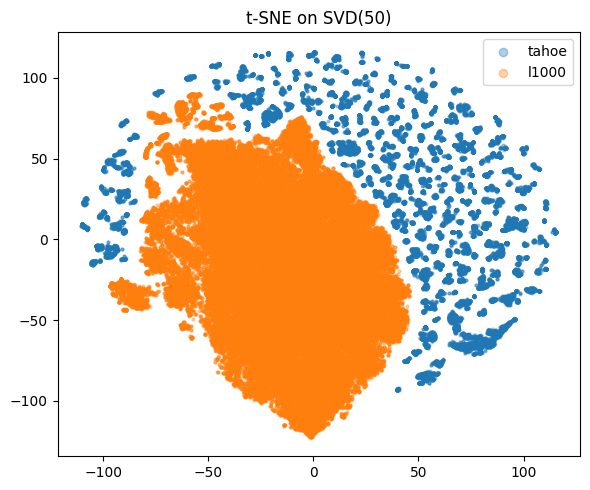

In [ ]:
# t-SNE on SVD(50)
T = TSNE(n_components=2, init='pca', perplexity=30, random_state=0, learning_rate='auto').fit_transform(Z50)
plt.figure(figsize=(6,5))
for d in adata_int.obs['dataset'].unique():
    m = adata_int.obs['dataset'].values==d
    plt.scatter(T[m,0], T[m,1], s=4, alpha=0.35, label=d)
plt.legend(markerscale=3); plt.title('t-SNE on SVD(50)'); plt.tight_layout()
plt.savefig('figs/12_tsne_svd50_by_dataset.png', dpi=150); plt.show()

### PaCMAP

In [ ]:
# PaCMAP
try:
    import pacmap
    pm = pacmap.PaCMAP(n_components=2, random_state=0)
    P = pm.fit_transform(Z50, init="pca")
    plt.figure(figsize=(6,5))
    for d in adata_int.obs['dataset'].unique():
        m = adata_int.obs['dataset'].values==d
        plt.scatter(P[m,0], P[m,1], s=4, alpha=0.35, label=d)
    plt.legend(markerscale=3); plt.title('PaCMAP on SVD(50)'); plt.tight_layout()
    plt.savefig('figs/13_pacmap_svd50_by_dataset.png', dpi=150); plt.show()
except Exception as e:
    print("PaCMAP skipped:", e)

## Trial

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [14]:
cells_tah = set(meta[meta['dataset'] == 'tahoe']['cell_std'])
cells_lin = set(meta[meta['dataset'] == 'l1000']['cell_std'])

In [15]:
only_tah = cells_tah - cells_lin

In [23]:
cl_meta = cl_info[['cell_name', 'Organ']].drop_duplicates()
cl_meta['cell_name'] = cl_meta['cell_name'].map(canon_cell)

In [36]:
cl_meta[cl_meta['cell_name'].isin(only_tah)].sort_values("Organ")

,cell_name,Organ
554,J82,Bladder/Urinary Tract
51,COLO205,Bowel
332,SW1417,Bowel
581,LS180,Bowel
394,HCT15,Bowel
493,SW48,Bowel
481,BT474,Breast
866,SW1088,CNS/Brain
856,H4,CNS/Brain
962,A172,CNS/Brain


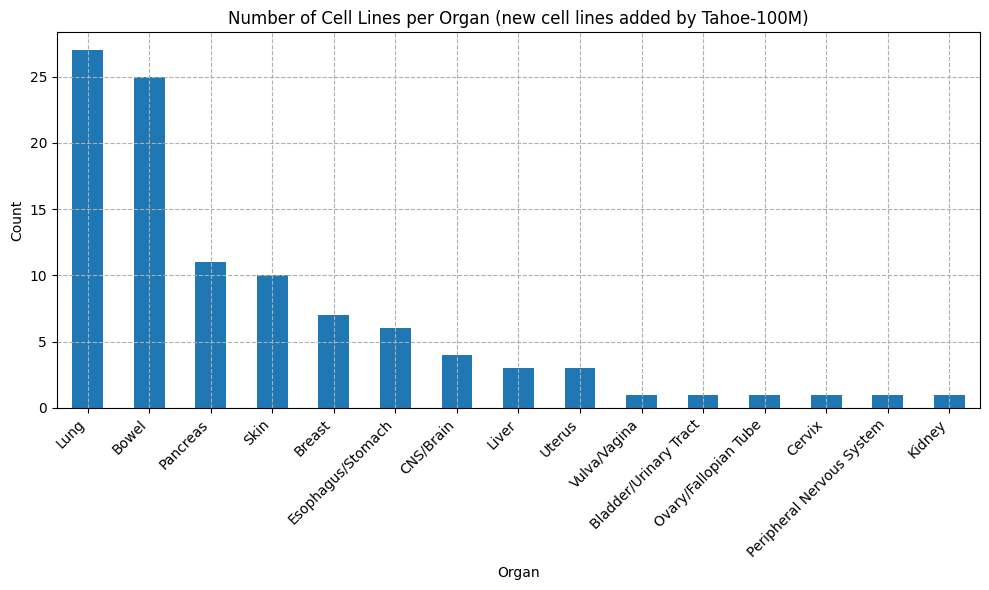

In [35]:
# Count number of cell lines per organ
organ_counts = cl_meta['Organ'].value_counts()

# Create a bar plot
plt.figure(figsize=(10, 6))
organ_counts.plot(kind='bar')
plt.title('Number of Cell Lines per Organ (new cell lines added by Tahoe-100M)')
plt.xlabel('Organ')
plt.ylabel('Count')
plt.grid(linestyle='--') 
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

In [38]:
tmp = pd.read_csv("../GSE70138_Broad_LINCS_cell_info_2017-04-28.txt", sep="\t")

In [39]:
tmp

,cell_id,cell_type,base_cell_id,precursor_cell_id,modification,sample_type,primary_site,subtype,original_growth_pattern,provider_catalog_id,original_source_vendor,donor_age,donor_sex,donor_ethnicity
0,A375,cell line,A375,-666,-666,tumor,skin,malignant melanoma,adherent,CRL-1619,ATCC,54,F,-666
1,A375.311,cell line,A375,A375,genetically modified to stably express Cas9 pr...,tumor,skin,malignant melanoma,adherent,CRL-1619,ATCC,54,F,-666
2,A549,cell line,A549,-666,-666,tumor,lung,non small cell lung cancer| carcinoma,adherent,CCL-185,ATCC,58,M,Caucasian
3,A549.311,cell line,A549,A549,genetically modified to stably express Cas9 p...,tumor,lung,non small cell lung cancer| carcinoma,adherent,CCL-185,ATCC,58,M,Caucasian
4,A673,cell line,A673,-666,-666,tumor,bone,ewing's sarcoma,adherent,CRL-1598,ATCC,-666,F,-666
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,CD34,primary,CD34,-666,-666,normal,bone,bone marrow,suspension,-666,-666,-666,-666,-666
94,PHH,primary,PHH,-666,-666,primary,liver,normal primary liver,-666,-666,CellzDirect,-666,-666,-666
95,SKB,primary,SKB,-666,-666,normal,muscle,myoblast,-666,CC-2580,Lonza,-666,-666,-666
96,SKL,primary,SKL,-666,-666,primary,muscle,normal primary skeletal muscle cells,adherent,CC-2561,LONZA,-666,-666,-666
